In [8]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random

In [6]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        if self.wealth == 0:
            return
        other_agent = random.choice(model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [9]:
model = MoneyModel(10)
for i in range(10):
    model.step()

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 4.,  0.,  0.,  3.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

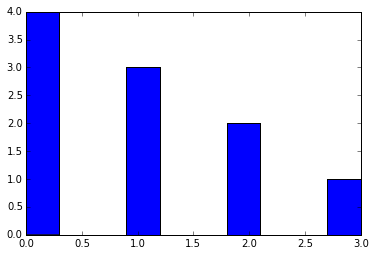

In [11]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([ 434.,  302.,  150.,   73.,   32.,    9.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

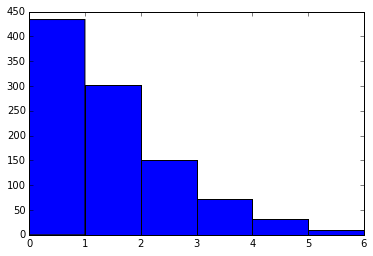

In [12]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [19]:
from mesa.space import MultiGrid

In [20]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def move(self, model):
        possible_steps = model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = random.choice(possible_steps)
        model.grid.move_agent(self, new_position)

    def give_money(self, model):
        cellmates = model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self, model):
        self.move(model)
        if self.wealth > 0:
            self.give_money(model)

In [21]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

In [23]:
import numpy as np

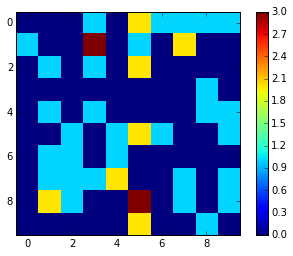

In [24]:
wealth_grid = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    cell_wealth = len(cell_content)
    wealth_grid[y][x] = cell_wealth
plt.imshow(wealth_grid, interpolation='nearest')
plt.colorbar()

In [25]:
from mesa.datacollection import DataCollector

In [26]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)


In [35]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})
        self.running = True

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [29]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

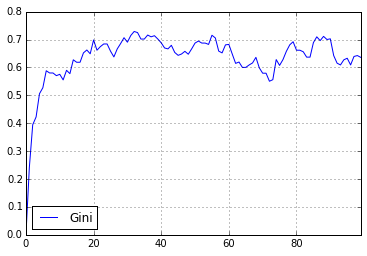

In [30]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [31]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

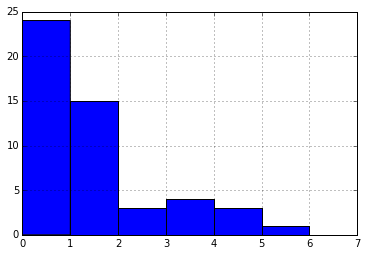

In [32]:
end_wealth = agent_wealth.xs(19, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))


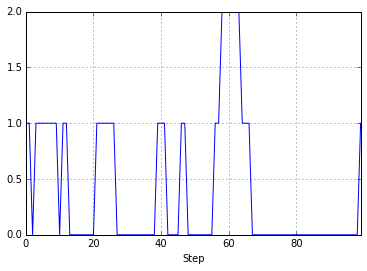

In [33]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [34]:
from mesa.batchrunner import BatchRunner

In [36]:
parameters = {"height": 10, "width": 10, "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel, parameters, iterations=5, max_steps=100,
           model_reporters={"Gini": compute_gini})
batch_run.run_all()

In [37]:
run_data = batch_run.get_model_vars_dataframe()